In [206]:
!mv /Users/chedges/Downloads/tpf_01.p data/

mv: /Users/chedges/Downloads/tpf_01.p: No such file or directory


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lamatrix as la
import pickle

In [2]:
result = pickle.load(open('data/tpf_01.p', 'rb'))
y, ye, ids, dx, dy, c, r, meta = result['y'], result['ye'], result['ids'], result['dx'], result['dy'], result['r'], result['c'], result["meta"]
rad, phi = np.hypot(dx, dy), np.arctan2(dy, dx)
brad, bphi = np.hypot(r - 1024, c - 1024), np.arctan2(c - 1024, r - 1024)

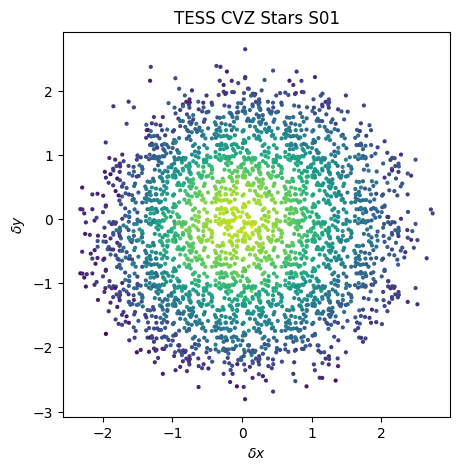

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))
#ax.errorbar(rad, y, ye, color='k', ls='', lw=0.3)
ax.scatter(dx, dy, c=np.nanmedian(y, axis=0), s=4)
ax.set(xlabel='$\delta x$', ylabel='$\delta y$', title='TESS CVZ Stars S01');

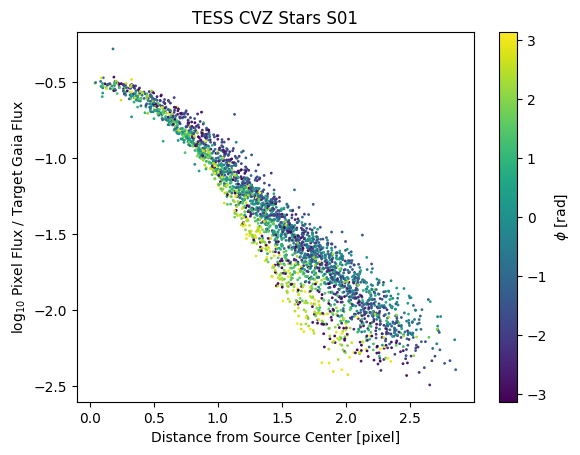

In [4]:
fig, ax = plt.subplots()
#ax.errorbar(rad, y, ye, color='k', ls='', lw=0.3)
im = ax.scatter(rad, np.nanmedian(y, axis=0), c=phi, s=1)
ax.set(xlabel='Distance from Source Center [pixel]', ylabel='log$_{10}$ Pixel Flux / Target Gaia Flux', title='TESS CVZ Stars S01');
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("$\phi$ [rad]")

Calculate the mean image and work with that

In [5]:
y0, ye0 = np.nanmean(y, axis=0), np.nansum(ye**2, axis=0)**0.5/ye.shape[0]

In [6]:
ccdmask = np.zeros(y0.shape, bool)
for id in [ticid for ticid, met in meta.items() if met['ccd'] == 1]:
    ccdmask |= (ids == id)

In [7]:
data_mask = (rad < 1) & ccdmask
g1 = la.lnGaussian2DGenerator('dx', 'dy', stddev_x_prior=(1, 1), stddev_y_prior=(1, 1))
g1.fit(dx=dx, dy=dy, data=y0, errors=ye0, mask=data_mask)

dg1 = g1.gradient
model = g1 + dg1
model.fit(dx=dx, dy=dy, data=y0, errors=ye0, mask=data_mask)

# model.fit(dx=dx, dy=dy, data=y0, error=ye0, mask=rad < 0.5)
# model[0].update_priors()
# model = model[0] + model[0].gradient
# model.fit(dx=dx, dy=dy, data=y0, errors=ye0)

dx2, dy2 = dx - model[1].shift_x[0], dy - model[1].shift_y[0]
g1.fit(dx=dx2, dy=dy2, data=y0, errors=ye0, mask=data_mask)
g1.update_priors()

sip_model = g1 + g1.gradient * (la.Polynomial1DGenerator('r', polyorder=1) * la.Polynomial1DGenerator('c', polyorder=1))
bc, br = (c - 1024)/2048, (r - 1024)/2048
bctest, brtest = (np.mgrid[-50:51, -50:51])/100

sip_model.fit(dx=dx2, dy=dy2, data=y0, errors=ye0, r=br, c=bc, mask=data_mask)


# # # best fit average shift
# # xshift, yshift = model[1].shift_x[0], model[1].shift_y[0]

# # model[0].update_priors()

/Users/chedges/Projects/lamatrix/src/lamatrix/generator.py:179: RuntimeWarning: divide by zero encountered in divide
  ) + np.diag(1 / self.prior_sigma**2)
/Users/chedges/Projects/lamatrix/src/lamatrix/generator.py:183: RuntimeWarning: invalid value encountered in divide
  ) + np.nan_to_num(self.prior_mu / self.prior_sigma**2)


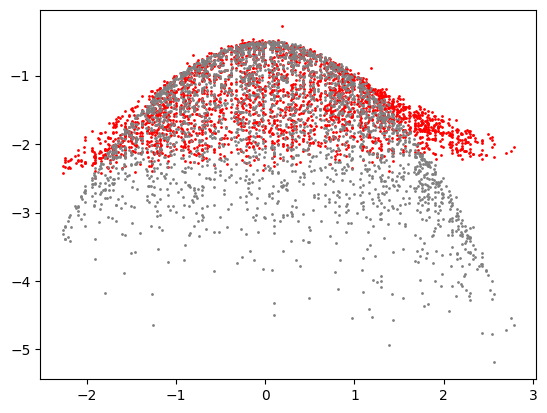

In [12]:
plt.scatter(dx2, y0, c='r', s=1)
#plt.scatter(dx2, g1(dx=dx2, dy=dy2, r=br, c=bc), s=1, c='lime')
plt.scatter(dx2, sip_model(dx=dx2, dy=dy2, r=br, c=bc), s=1, c='grey')

In [15]:
dg1 = g1.gradient

Calculate the shift in every frame

In [16]:
xs, ys = [], []
for cadence in np.arange(0, len(y)):
    dg1.fit(dx=dx2, dy=dy2, r=br, c=bc, mask=data_mask, data=y[cadence] - sip_model(dx=dx2, dy=dy2, r=br, c=bc), errors=ye[cadence])
    xs.append(dg1.shift_x)
    ys.append(dg1.shift_y)

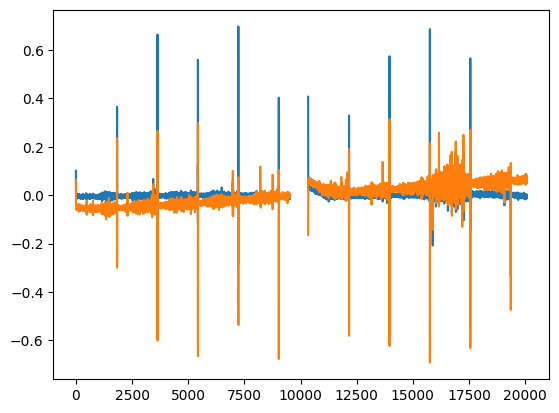

In [17]:
plt.plot(np.asarray(xs)[:, 0])
plt.plot(np.asarray(ys)[:, 0])

In [18]:
dx3, dy3 = ((dx2[:, None] - np.asarray(xs)[:, 0])), ((dy2[:, None] - np.asarray(ys)[:, 0]))

In [19]:
time_mask = np.isfinite(y).all(axis=1)
time_mask &= np.hypot(np.gradient(np.asarray(xs)[:, 0]), np.gradient(np.asarray(ys)[:, 0])) < 0.05

In [20]:
sip_model.fit(dx=dx3[data_mask][:, time_mask].ravel(),
             dy=dy3[data_mask][:, time_mask].ravel(),
             r=br[data_mask, None] * np.ones(time_mask.sum()),
             c=bc[data_mask, None] * np.ones(time_mask.sum()),
             data=y.T[data_mask][:, time_mask].ravel(),
             error=ye.T[data_mask][:, time_mask].ravel())

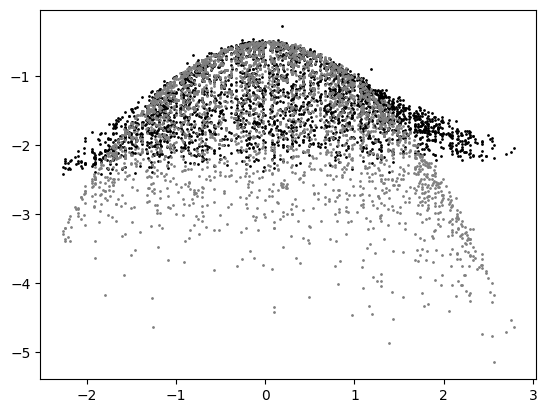

In [21]:
plt.scatter(dx2, y0, c='k', s=1)
plt.scatter(dx2, sip_model(dx=dx2, dy=dy2, r=br, c=bc), s=1, c='grey')

In [54]:
rad, phi = np.hypot(dx2, dy2), np.arctan2(dy2, dx2)
#r1 = la.Spline1DGenerator(knots=np.arange(0, 3, 0.5), x_name='rad')
r1 = la.Polynomial1DGenerator(polyorder=4, x_name='rad')
r1.fit(rad=rad, data=y0 - sip_model[1](dx=dx, dy=dy, r=br, c=bc), error=ye0)
r1.update_priors()

p1 = la.BoundedGenerator(la.SinusoidGenerator('phi', nterms=3, prior_sigma=np.ones(7) * 1e4), [(0.5, 100)], 'rad', 1)
psf_model = r1 * p1

psf_model.fit(rad=rad, phi=phi, data=y0 - sip_model[1](dx=dx, dy=dy, r=br, c=bc), error=ye0, mask=ccdmask)

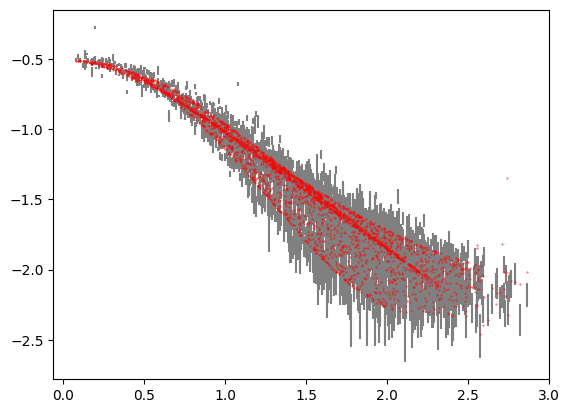

In [56]:
tdx = 200
plt.errorbar(rad, y[tdx], ye[tdx], ls='', c='grey')
plt.scatter(rad, psf_model(rad=np.hypot(dx2 - xs[tdx][0], dy2 - ys[tdx][0]), phi=np.arctan2(dy2 - ys[tdx][0], dx2 - xs[tdx][0])), s=0.1, c='r', zorder=10)

In [644]:
w, we = np.zeros((2, y.shape[0], len(np.unique(ids[ccdmask]))))
for tdx in range(6000):
    f = 10**y[tdx][ccdmask]
    fe = ye[0][ccdmask] * np.log(10)/2.5 * f
    m = 10**psf_model(rad=np.hypot(dx2 - xs[tdx][0], dy2 - ys[tdx][0])[ccdmask], phi=np.arctan2(dy2 - ys[tdx][0], dx2 - xs[tdx][0])[ccdmask])
    X = (m * masks[:, ccdmask]).T
    sigma_w_inv = X.T.dot(X/fe[:, None]**2)
    w[tdx] = np.linalg.solve(sigma_w_inv, X.T.dot(f/fe**2))
    #we[tdx] = np.linalg.inv(sigma_w_inv).diagonal()**0.5    

KeyboardInterrupt: 

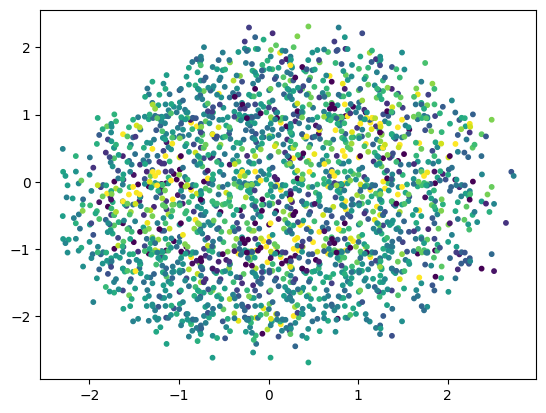

In [646]:
plt.scatter(dx[ccdmask], dy[ccdmask], c=(f - X.dot(w[tdx]**0))/fe, vmin=-10, vmax=10, s=10)

<ErrorbarContainer object of 3 artists>

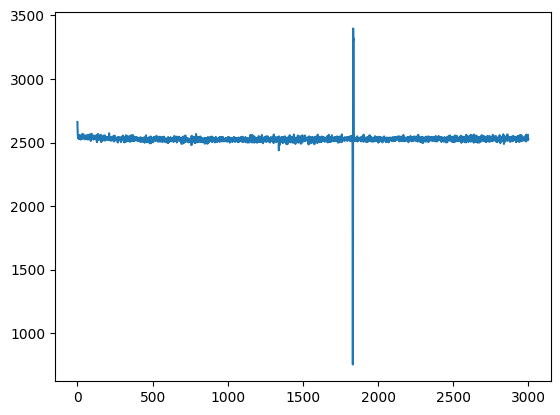

In [668]:
sdx = 50
plt.errorbar(np.arange(len(y))[:3000], w[:, sdx][:3000] * meta[np.unique(ids[ccdmask])[sdx]]['tflux'])
#plt.ylim(0.6, 1.6)

ValueError: too many values to unpack (expected 1)

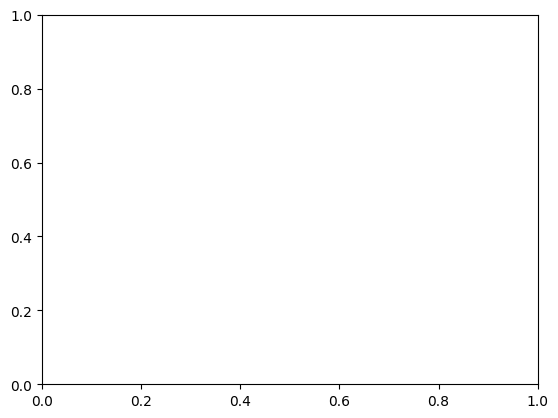

In [648]:
plt.errorbar(np.arange(len(w)), w, we)

<ErrorbarContainer object of 3 artists>

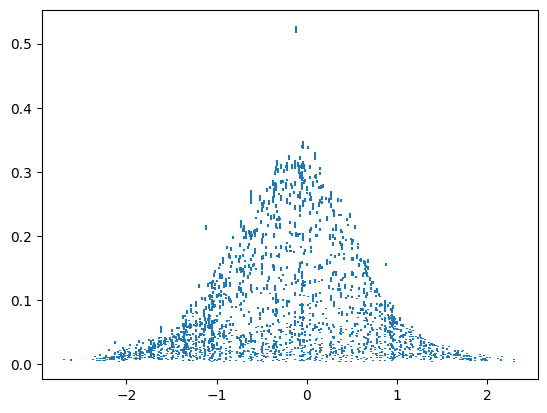

In [415]:

plt.errorbar(dy[ccdmask], f, fe, ls='')

In [348]:
masks = np.asarray([ids == id for id in [ticid for ticid, met in meta.items() if met['ccd'] == 1]])

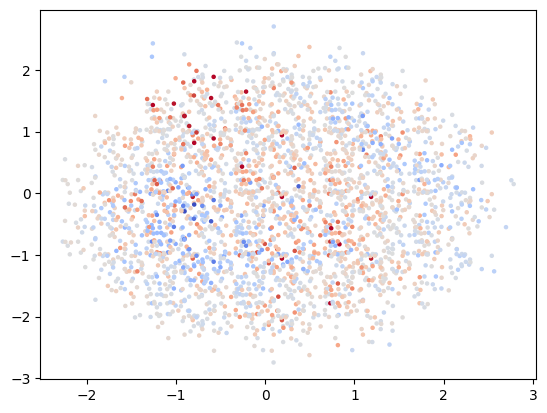

In [376]:
tdx = 1000 
m = psf_model(rad=np.hypot(dx2 - xs[tdx][0], dy2 - ys[tdx][0]), phi=np.arctan2(dy2 - ys[tdx][0], dx2 - xs[tdx][0]))
plt.scatter(dx2, dy2, c=(y[tdx] - m)/ye[tdx], s=5, cmap='coolwarm', vmin=-10, vmax=10)


In [370]:
# masks = [ids == id for id in [ticid for ticid, met in meta.items() if met['ccd'] == 1]]
# fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
# xs, ys = [], []
# mg = g1.gradient
# for mask in masks:
#     mg.fit(dx=dx2, dy=dy2, data=y0 - g1(dx=dx2, dy=dy2, r=br, c=bc), error=ye0, mask=mask & (rad < 1))
#     xs.append(mg.shift_x[0])
#     ys.append(mg.shift_y[0])
# ax[0].hist(xs, np.linspace(-1, 1, 100));
# ax[1].hist(ys, np.linspace(-1, 1, 100));


In [371]:
model[1].shift_x[0], model[1].shift_y[0]

(-0.03414833081997324, -0.05659394237616518)

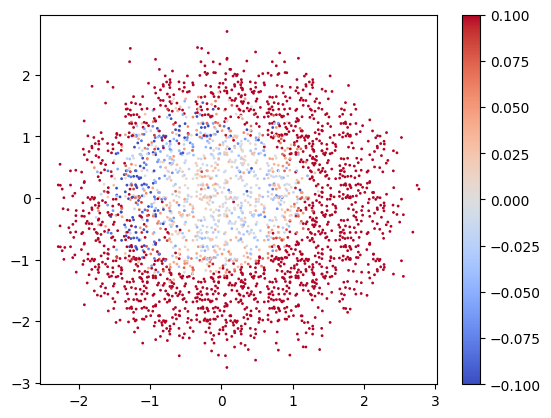

In [372]:
plt.scatter(dx2, dy2, c=y0 - sip_model(dx=dx2, dy=dy2, r=br, c=bc), cmap='coolwarm', s=1, vmin=-0.1, vmax=0.1)
plt.colorbar()

In [373]:
masks = [ids == id for id in [ticid for ticid, met in meta.items() if met['ccd'] == 1]]

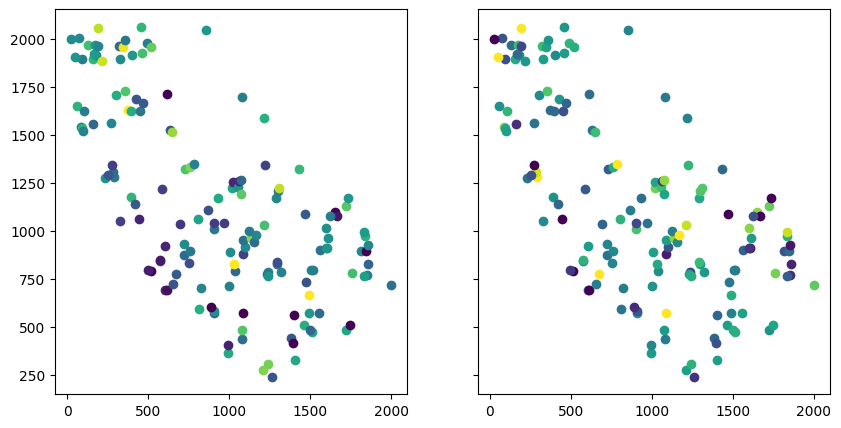

In [380]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
mg = model[0].gradient
for mask in masks:
    mg.fit(dx=dx2, dy=dy2, data=y0 - sip_model(dx=dx2, dy=dy2, r=br, c=bc), error=ye0, mask=mask & (rad < 1))
    ax[0].scatter(c[mask].mean(), r[mask].mean(), c=mg.shift_x[0], vmin=-0.1, vmax=0.1)
    ax[1].scatter(c[mask].mean(), r[mask].mean(), c=mg.shift_y[0], vmin=-0.1, vmax=0.1)

In [375]:
poly = la.Polynomial1DGenerator('bc', polyorder=3) * la.Polynomial1DGenerator('br', polyorder=3) * model[0].gradient

In [376]:
model2 = (model[0] + poly)
model2.fit(dx=dx, dy=dy, bc=bc, br=br, data=y0, errors=ye0, mask=np.asarray(masks).any(axis=0))

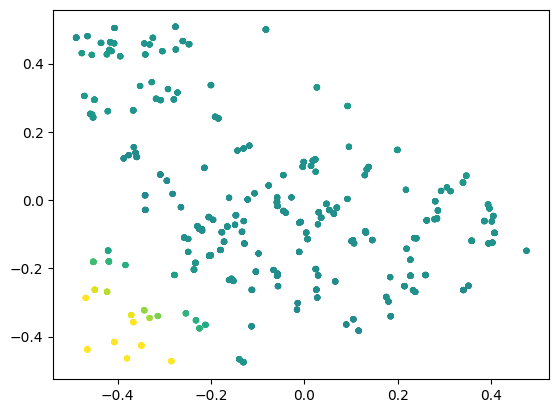

In [377]:
plt.scatter(bc, br, c=model2[1](dx=dx*0, dy=dy*0, bc=bc, br=br), vmin=-0.2, vmax=0.2, s=10)

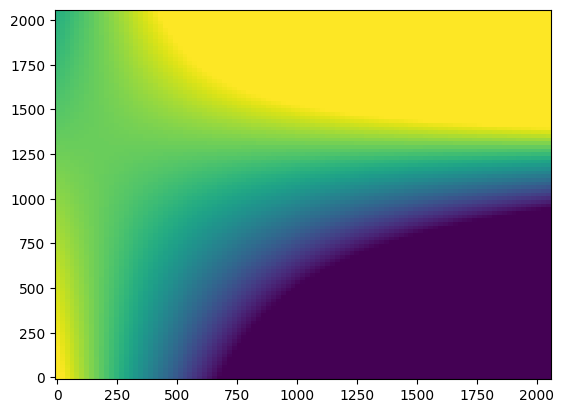

In [378]:
plt.pcolormesh(bctest * 2048 + 1024, brtest * 2048 + 1024, sip_model[1](c=bctest, r=brtest, dx=bctest*0, dy=bctest*0).reshape(bctest.shape), vmin=-0.01, vmax=0.01)
# plt.colorbar()
# plt.scatter(bc * 2048 + 1024, br * 2048 + 1024, vmin=-0.01, vmax=0.01, s=100, zorder=100, c=sip_model[1](dx=dx*0, dy=dy*0, bc=bc, br=br), edgecolor='r')


In [287]:
model[0].gradient

dlnGaussian2DGenerator(dx, dy)[n, 3] 

In [72]:
model = model[0] + model[0].gradient

In [264]:
#r1 = la.Spline1DGenerator(np.linspace(0, 3, 6), 'r')
r1 = la.Polynomial1DGenerator('r', polyorder=2)
p1 = la.SinusoidGenerator('phi', nterms=2)
psf = r1 * p1

In [265]:
xshift, yshift = [], []
psf_mu = []
for idx in range(200):
    model.fit(dx=dx, dy=dy, data=y[idx], errors=ye[idx])
    xshift.append(model[1].shift_x)
    yshift.append(model[1].shift_y)

    rad, phi = np.hypot(dx - model[1].shift_x[0], dy - model[1].shift_y[0]), np.arctan2(dy - model[1].shift_y[0], dx - model[1].shift_x[0])
    psf.fit(r=rad, phi=phi, data=y[idx], errors=ye[idx])
    psf_mu.append(psf.mu)
xshift, yshift, psf_mu = np.asarray(xshift), np.asarray(yshift), np.asarray(psf_mu)

In [266]:
Rtest, Ctest = (np.mgrid[-400:401, -400:401])/100

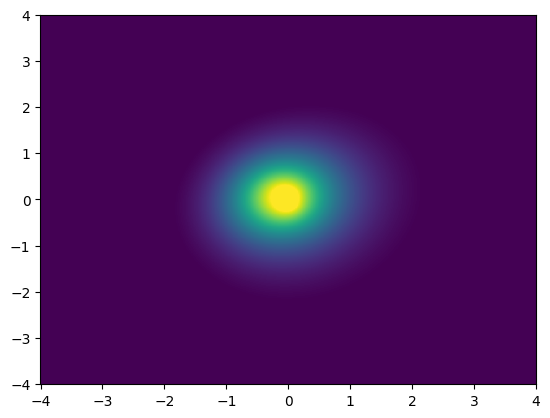

In [276]:
psf.fit_mu = psf_mu[0]
plt.pcolormesh(Ctest, Rtest, 10**psf(r=np.hypot(Rtest, Ctest), phi=np.arctan2(Rtest, Ctest)).reshape(Rtest.shape), vmin=0.01, vmax=0.3)

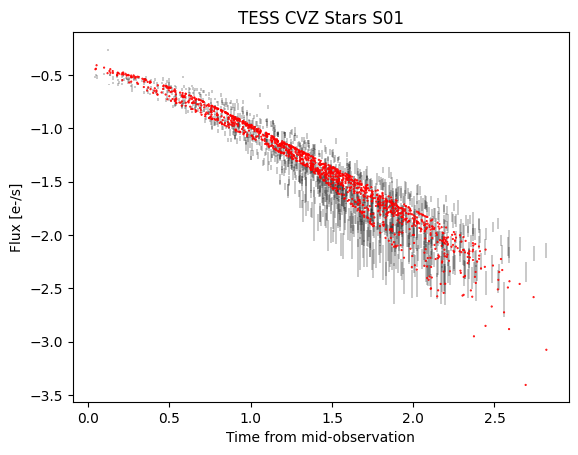

In [277]:
fig, ax = plt.subplots()
ax.errorbar(rad, y[0], ye[0], color='k', ls='', lw=0.3)
ax.scatter(rad, psf(r=rad, phi=phi), c='r', ls='', s=0.3, zorder=10)
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='TESS CVZ Stars S01');

<ErrorbarContainer object of 3 artists>

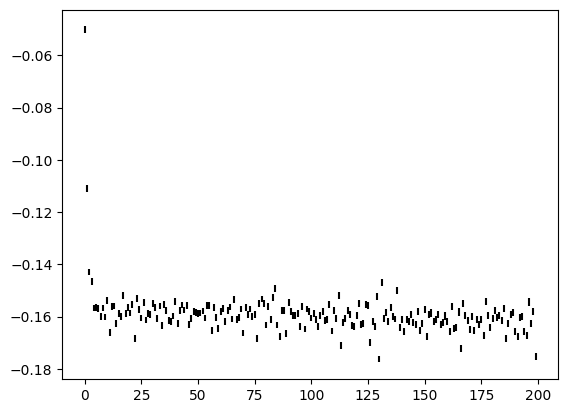

In [234]:
plt.errorbar(np.arange(yshift.shape[0]), y=yshift[:, 0], yerr=yshift[:, 1], c='k', ls='')

dlnGaussian2DGenerator(y, x)[n, 3] 

In [99]:
model[1].fit_mu

array([-0.        ,  0.04371064, -0.16055104])

<ErrorbarContainer object of 3 artists>

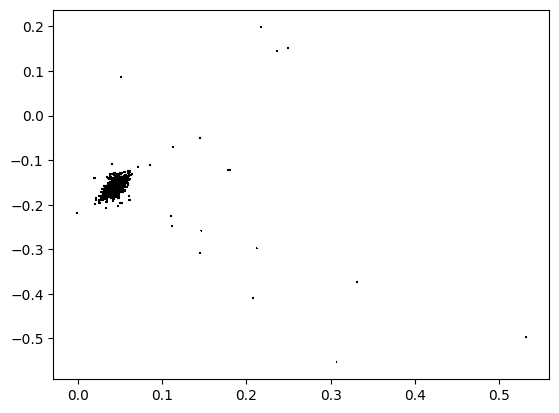

In [87]:
plt.errorbar(x=xshift[:, 0], y=yshift[:, 0], xerr=xshift[:, 1], yerr=yshift[:, 1], c='k', ls='')

In [36]:
rad, phi = np.hypot(dx - xshift, dy - yshift), np.arctan2(dy - yshift, dx - xshift)
r1 = la.Spline1DGenerator(np.linspace(0, 3, 6), 'r')
p1 = la.SinusoidGenerator('phi', nterms=3)
model = r1 * p1

In [37]:
r1 = la.Spline1DGenerator(np.linspace(0, 3, 6), 'r')
p1 = la.SinusoidGenerator('phi', nterms=3)
model = r1 * p1

In [39]:
model.fit(r=rad, phi=phi, data=np.nanmean(y, axis=0), errors=np.nansum(ye**2, axis=0)**0.5/ye.shape[0])

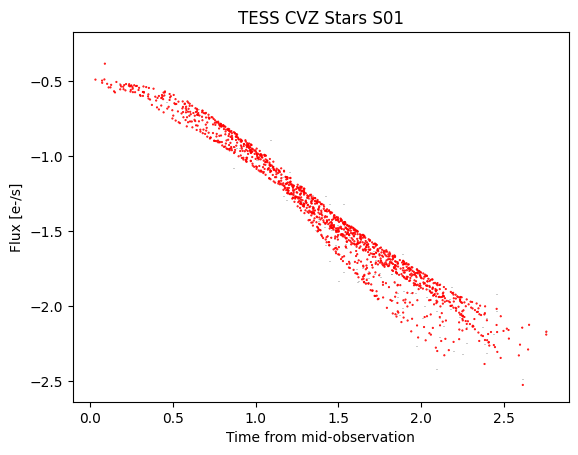

In [41]:
fig, ax = plt.subplots()
ax.errorbar(rad, np.nanmean(y, axis=0), np.nansum(ye**2, axis=0)**0.5/ye.shape[0], color='k', ls='', lw=0.3)
ax.scatter(rad, model(r=rad, phi=phi), c='r', ls='', s=0.3, zorder=10)
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='TESS CVZ Stars S01');

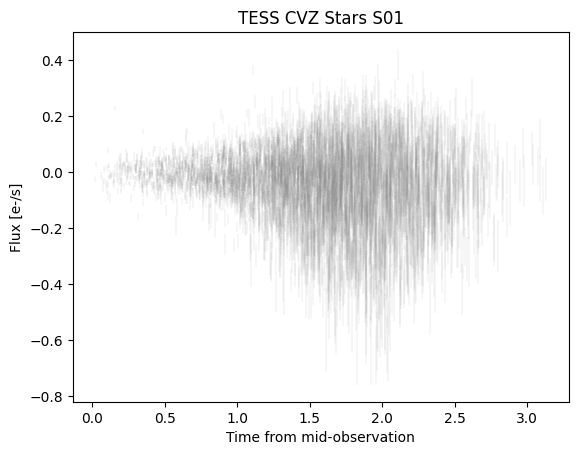

In [14]:
fig, ax = plt.subplots()
#ax.errorbar(rad, y, ye, color='k', ls='', lw=0.3)
ax.errorbar(rad, y - model(r=rad, phi=phi), ye, c='grey', ls='', lw=0.1)
ax.set(xlabel='Time from mid-observation', ylabel='Flux [e-/s]', title='TESS CVZ Stars S01');

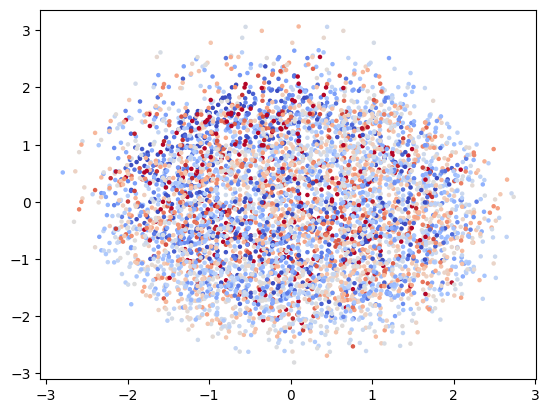

In [15]:
plt.scatter(dx, dy, c=(y - model(r=rad, phi=phi))/ye, s=5, vmin=-5, vmax=5, cmap='coolwarm')